In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data processing and manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import seaborn as sns

# Configure visualization
%matplotlib inline
plb.rcParams['figure.figsize'] = 10, 8
mpl.style.use('ggplot')
sns.set_style('white')

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Accuracy Metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from sklearn.preprocessing import LabelEncoder

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
full = pd.concat([train,test], axis = 0)
print(full.describe(include = [int, float, object]))

        ApplicantIncome  CoapplicantIncome  Credit_History Dependents  \
count        981.000000         981.000000      902.000000        956   
unique              NaN                NaN             NaN          4   
top                 NaN                NaN             NaN          0   
freq                NaN                NaN             NaN        545   
mean        5179.795107        1601.916330        0.835920        NaN   
std         5695.104533        2718.772806        0.370553        NaN   
min            0.000000           0.000000        0.000000        NaN   
25%         2875.000000           0.000000        1.000000        NaN   
50%         3800.000000        1110.000000        1.000000        NaN   
75%         5516.000000        2365.000000        1.000000        NaN   
max        81000.000000       41667.000000        1.000000        NaN   

       Education Gender  LoanAmount  Loan_Amount_Term   Loan_ID Loan_Status  \
count        981    957  954.000000        9

In [56]:
full.head()

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Property_Area,Self_Employed
0,5849,0.0,1.0,0,Graduate,Male,NaN,360.0,LP001002,1,No,Urban,No
1,4583,1508.0,1.0,1,Graduate,Male,128.0,360.0,LP001003,0,Yes,Rural,No
2,3000,0.0,1.0,0,Graduate,Male,66.0,360.0,LP001005,1,Yes,Urban,Yes
3,2583,2358.0,1.0,0,Not Graduate,Male,120.0,360.0,LP001006,1,Yes,Urban,No
4,6000,0.0,1.0,0,Graduate,Male,141.0,360.0,LP001008,1,No,Urban,No


In [57]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB
None


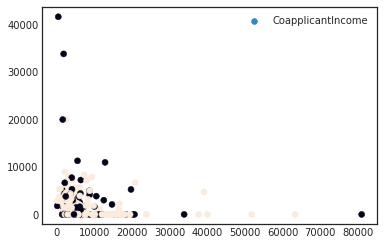

In [58]:
status = full.Loan_Status
status[status == 'Y'] = 2
status[status == 'N'] = 5
status[status == np.nan] = 999
plt.scatter(x = full.ApplicantIncome, y = full.CoapplicantIncome, c = full.Loan_Status.reshape(-1))
plt.legend()
plt.show()


In [5]:
full.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'Credit_History', 'Dependents',
       'Education', 'Gender', 'LoanAmount', 'Loan_Amount_Term', 'Loan_ID',
       'Loan_Status', 'Married', 'Property_Area', 'Self_Employed'],
      dtype='object')

##### Imputing the quantitative variables with median values.

In [6]:
full.Loan_Amount_Term.fillna(full.Loan_Amount_Term.median(), inplace = True)
full.LoanAmount.fillna(full.LoanAmount.median(), inplace = True)

### Manually encoding the nominal and ordinal variables.

##### Imputing the categorical variables with most common response

In [7]:
full.Gender.fillna('Male', inplace = True)
full.Dependents.fillna('0', inplace = True)
full.Credit_History.fillna(1, inplace = True)
full.Self_Employed.fillna('No', inplace = True)
full.Married.fillna('Yes', inplace = True)
train = full.iloc[:614,:]
test = full.iloc[614:, :]

## Feature Engineering

In [8]:
full['TotalIncome'] = full.ApplicantIncome + full.CoapplicantIncome
full['IncomeDebtRatio'] = full.TotalIncome / full.LoanAmount
train = full.iloc[:614,:]
test = full.iloc[614:, :]
full.head()

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Property_Area,Self_Employed,TotalIncome,IncomeDebtRatio
0,5849,0.0,1.0,0,Graduate,Male,126.0,360.0,LP001002,Y,No,Urban,No,5849.0,46.420635
1,4583,1508.0,1.0,1,Graduate,Male,128.0,360.0,LP001003,N,Yes,Rural,No,6091.0,47.585938
2,3000,0.0,1.0,0,Graduate,Male,66.0,360.0,LP001005,Y,Yes,Urban,Yes,3000.0,45.454545
3,2583,2358.0,1.0,0,Not Graduate,Male,120.0,360.0,LP001006,Y,Yes,Urban,No,4941.0,41.175000
4,6000,0.0,1.0,0,Graduate,Male,141.0,360.0,LP001008,Y,No,Urban,No,6000.0,42.553191


In [98]:
def model_classifier(model,X, y):
    #Fitting the model with training data
    model.fit(X, y)
    
    #Calculating the Train Accuracy:
    train_predict = model.predict(X)
    print('Train Accurcay Score : ', accuracy_score(y, train_predict))
    
    #Calculating the cross validation score
    kfold = StratifiedKFold(n_splits = 4)
    scores = []
    
    # Performing K Fold Cross validation test.
    for train_index, test_index in kfold.split(X, y):
        model.fit(X.iloc[train_index,:], y.iloc[train_index,:])
        prediction = model.predict(X.iloc[test_index, :])
        scores.append(accuracy_score(y.iloc[test_index, :], prediction))
    
    #Printing the K Fold validation score
    print('\nKFold Score : ', np.mean(scores))
    
    # Since this is a classification problem 
    # Printing the confusion matrix
    conf_mat = confusion_matrix(y.iloc[test_index,:], prediction)
    print('\nConfusion Matrix')
    print(conf_mat)
    

    # print('\nProportioanl confusion_matrix\n')
    # print(conf_mat/conf_mat[:].sum())    
    
    # Print the ROC-AUC score
    # y_test_series = 
    # label_encoder = LabelEncoder()
    # label_encoder.fit(y_test_series)
    # y_test_series = label_encoder.transform(y_test_series)
    # pd.Series(y.iloc[test_index,:])
    # print('ROC-AUC Score ',roc_auc_score(y_test_series
    #                                    , model.decision_function(X.iloc[test_index,:])))    

In [10]:
features = ['Credit_History','Dependents',
       'Education', 'LoanAmount', 'Loan_Amount_Term', 
       'Married', 'Property_Area', 
       'TotalIncome', 'IncomeDebtRatio']
response = ['Loan_Status']
X = pd.get_dummies(train[features])
y = train[response]

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_labelled = encoder.fit_transform(y)
# Unused features
# 'ApplicantIncome', 'CoapplicantIncome',

### Trying different Classification Models.

#### Logistic Regression

In [11]:
logistic = LogisticRegression()
model_classifier(logistic, X, y)

Train Accurcay Score :  0.8078175895765473

KFold Score :  0.807879212290977

Confusion Matrix
[[ 24  24]
 [  2 103]]


#### Decision Tree Classifier

In [12]:
decisiontree = DecisionTreeClassifier()
model_classifier(decisiontree, X, y)

Train Accurcay Score :  1.0

KFold Score :  0.6938396570749511

Confusion Matrix
[[21 27]
 [24 81]]


#### Naive Bayes

In [13]:
bayes = GaussianNB()
model_classifier(bayes, X, y)

Train Accurcay Score :  0.8029315960912052

KFold Score :  0.7866692131398014

Confusion Matrix
[[28 20]
 [12 93]]


#### K Nearest Neighbors 


In [14]:
knn = KNeighborsClassifier(n_neighbors = 1)
model_classifier(knn, X, y)

Train Accurcay Score :  1.0

KFold Score :  0.5651472710296239

Confusion Matrix
[[17 31]
 [29 76]]


#### Random Forest Classifier

In [15]:
randomforest = RandomForestClassifier()
model_classifier(randomforest, X, y)
randomforest.feature_importances_

Train Accurcay Score :  0.993485342019544

KFold Score :  0.750901875901876

Confusion Matrix
[[24 24]
 [19 86]]


array([0.23426143, 0.17109494, 0.02891214, 0.17919994, 0.22673437,
       0.01328212, 0.01459609, 0.01105066, 0.01189087, 0.00815558,
       0.01230374, 0.01483926, 0.01918325, 0.02157318, 0.02002297,
       0.01289945])

#### Support Vector Classifier 


In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns= X.columns)
svclassifier = SVC()
model_classifier(svclassifier, X_scaled, y)

Train Accurcay Score :  0.8094462540716613

KFold Score :  0.8095025889143536

Confusion Matrix
[[ 23  25]
 [  1 104]]


## Principal Component Analysis

In [65]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=16)
X_normailesed = StandardScaler().fit_transform(X)
pca.fit(X_normailesed)
print(pca)
X_pca = pca.transform(X_normailesed)

PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)


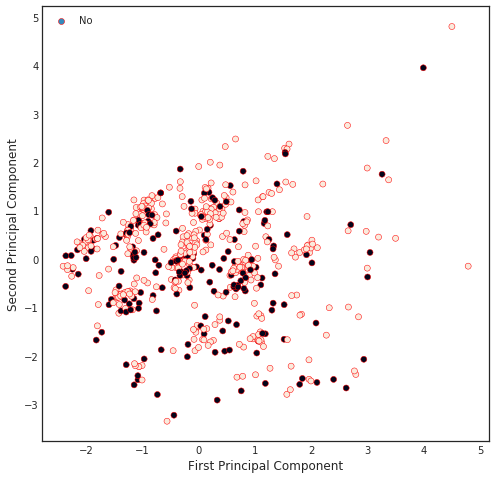

In [35]:
plt.figure(figsize= (8,8))
plt.scatter(X_pca[:,4],X_pca[:,5], c = y_labelled, edgecolors='red')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(['No', 'Yes'])
plt.show()

In [26]:
(pca.components_)

array([[ 1.30922152e-04,  2.42362039e-01, -1.20268896e-01,
         2.07892315e-01,  2.31087039e-02, -4.48540567e-01,
         1.92526064e-01,  2.61742126e-01,  1.89191139e-01,
         4.42850966e-02, -4.42850966e-02, -5.17126851e-01,
         5.17126851e-01, -2.85344949e-02, -2.37310243e-03,
         3.00514455e-02],
       [ 7.78288911e-02,  2.60072954e-01,  6.57270602e-02,
         3.40864687e-01,  2.15297789e-01,  9.75224998e-02,
         2.14223097e-03, -1.12353879e-01, -2.59954927e-02,
         5.91249036e-01, -5.91249036e-01,  1.05930581e-01,
        -1.05930581e-01, -1.01097817e-01,  5.83854651e-02,
         3.74881917e-02]])

### Trying to train svc model on new X_pca data

In [100]:
svc = SVC(kernel = 'linear')
X_pca_df = pd.DataFrame(X_pca)
model_classifier(svc, X_pca_df, y)

Train Accurcay Score :  0.8094462540716613

KFold Score :  0.8095025889143536

Confusion Matrix
[[ 23  25]
 [  1 104]]
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


#### Gradient Boosting Classifier

In [87]:
gbclassifier = GradientBoostingClassifier()
model_classifier(gbclassifier, X, y)

Train Accurcay Score :  0.8876221498371335

KFold Score :  0.7948285374755963

Confusion Matrix
[[24 24]
 [11 94]]


TypeError: fit_transform() missing 1 required positional argument: 'y'

#### Adaptive Boosting Classifier

In [56]:
abclassifier = AdaBoostClassifier()
model_classifier(abclassifier, X, y)

Train Accurcay Score :  0.8648208469055375

KFold Score :  0.8013114336643749

Confusion Matrix
[[27 21]
 [13 92]]


#### XGBoost Classifier

In [74]:
xgb = XGBClassifier(objective= 'binary:logistic', eval_metric = 'auc', scale_pos_weight=0.35, early_stopping_rounds=100)
model_classifier(xgb, X, y)

Train Accurcay Score :  0.8631921824104235

KFold Score :  0.731294032764621

Confusion Matrix
[[31 17]
 [24 81]]


/home/sagar/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sagar/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sagar/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sagar/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Return

### Conclusion
The Naive bayes and xgboost are performing very well.

In [40]:
import mglearn

In [43]:
dir(mglearn.plot_cross_validation)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'np',
 'plot_cross_validation',
 'plot_group_kfold',
 'plot_shuffle_split',
 'plot_stratified_cross_validation',
 'plot_threefold_split',
 'plt']

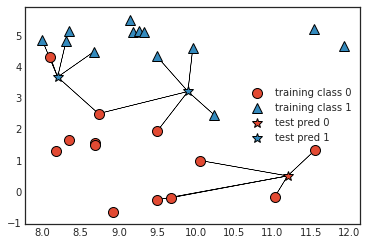

In [51]:
mglearn.plot_knn_classification.plot_knn_classification(n_neighbors= 5)